# Imports

In [1]:
%%capture
!chmod -R 777 ../

# conda install -c conda-forge cudatoolkit=11.8.0
# python3 -m pip install nvidia-cudnn-cu11==8.6.0.163 tensorflow==2.13.*
# mkdir -p $CONDA_PREFIX/etc/conda/activate.d
# echo 'CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))' >> $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh
# echo 'export LD_LIBRARY_PATH=$CONDA_PREFIX/lib/:$CUDNN_PATH/lib:$LD_LIBRARY_PATH' >> $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh
# source $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh
# # Verify install:
# python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

# conda install ipykernel

# !pip install pandas seaborn numpy matplotlib scikit-learn tifffile scikit-image tqdm opencv-python rasterio ultralytics

In [2]:
# System and path operations
import sys
import os
import datetime
from pathlib import Path
from glob import glob
sys.path.insert(0, '../')

# Imported local modules
from src.config import *
from src.utils import *
from src.models_arch import *
from src.models_utils import *

# Basic python data handling and visualization libraries
import random
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Libraries for image processing
from PIL import Image
import skimage
from skimage.io import imread, imsave
import tifffile as tiff

# Libraries for model evaluation and validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, jaccard_score


# TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import keras
from keras import backend as K
from keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau, 
                             CSVLogger, EarlyStopping)
from keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# Setting GPU's number
physical_devices=tf.config.experimental.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
# tf.config.set_visible_devices(physical_devices[:],'GPU')
tf.config.set_visible_devices(physical_devices[2],'GPU')

In [5]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=10240)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [6]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [7]:
# %tensorboard --logdir logs/fit 

In [8]:
# Clear any logs from previous runs
# !rm -rf ../logs/

# Model Hyperparameters

In [9]:
# model_name = 'UNet'
# model_name = 'UNetPlusPlus'
model_name = 'CloudXNet'

# Define batch size
batch_size = 16

train_with_RGB = False

# learning rate
# LR = 0.0005
# LR = 0.0001
LR = 1e-4

NUM_EPOCHS=500

model_name = f'{model_name}_SPARCS_epochs{NUM_EPOCHS}_batch{batch_size}'

model_name

'CloudXNet_SPARCS_epochs500_batch16'

In [10]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
optimizer = tf.keras.optimizers.Nadam(learning_rate=LR)
# optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=LR)

metrics = ['binary_crossentropy', jaccard_coef_loss, jaccard_coef, jaccard_coef_thresholded, 'accuracy', tf.keras.metrics.AUC()]
metrics = [jacc_coef, tf.keras.metrics.AUC()]


loss = 'binary_crossentropy'
loss = jacc_coef
# loss = tf.keras.losses.BinaryFocalCrossentropy()
# loss = bce_dice_loss

model = create_model(model_name='CXNet', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
# model = create_model(model_name='unet')
# model = create_model(model_name='rs_net')
# model = create_model(model_name='cloud_net')

2023-08-16 07:49:10.066612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 07:49:10.577755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


# Data loading

## Gen 1

In [11]:
train_image_names = sorted(os.listdir(Path(sparcs_train_dir, "images_p/")))
valid_image_names = sorted(os.listdir(Path(sparcs_valid_dir, "images_p/")))
steps_per_epoch = math.ceil(len(train_image_names) / batch_size)
validation_steps = math.ceil(len(valid_image_names) / batch_size)
steps_per_epoch, validation_steps

(46, 16)

In [12]:
test_image_names = sorted(os.listdir(Path(sparcs_test_dir, "images_p/")))
total_test_samples = math.ceil(len(test_image_names) / batch_size)

In [13]:
train = get_SPARCS_generator('train', batch_size=batch_size, shuffle=True, only_rgb=train_with_RGB)
valid = get_SPARCS_generator('valid', batch_size=batch_size, only_rgb=train_with_RGB)
test = get_SPARCS_generator('test', batch_size=batch_size, only_rgb=train_with_RGB)

In [32]:
X_test, y_test = get_SPARCS('test', only_rgb=train_with_RGB)

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Step 1: Create and initialize the generator (example for the training set)
# train_generator = get_SPARCS_generator(sets='train', batch_size=32, shuffle=True)

# # Step 2: Get a batch of data from the generator
# batch_images, batch_masks = next(train_generator)

# # Step 3: Print the shapes of the images and masks in the batch
# print("Batch of Images shape:", batch_images.shape)
# print("Batch of Masks shape:", batch_masks.shape)

# # Step 4: Display some example images along with their masks
# num_examples_to_display = 4
# for i in range(num_examples_to_display):
#     plt.subplot(2, num_examples_to_display, i + 1)
#     plt.imshow(batch_images[i])
#     plt.title("Image")
#     plt.axis("off")

#     plt.subplot(2, num_examples_to_display, i + num_examples_to_display + 1)
#     plt.imshow(batch_masks[i][:, :, 0], cmap="gray")
#     plt.title("Mask")
#     plt.axis("off")

# plt.show()

## tf.Data

In [13]:
train_image_size = len(sorted(os.listdir(Path(sparcs_train_dir, "images_p/"))))
valid_image_size = len(sorted(os.listdir(Path(sparcs_valid_dir, "images_p/"))))

In [14]:
train = tf.data.Dataset.from_tensor_slices(get_SPARCS(only_rgb=train_with_RGB))
valid = tf.data.Dataset.from_tensor_slices(get_SPARCS('valid', only_rgb=train_with_RGB))
test = tf.data.Dataset.from_tensor_slices(get_SPARCS('test', only_rgb=train_with_RGB))

train = train.shuffle(train_image_size, seed=seed_value).batch(batch_size)
valid = valid.shuffle(valid_image_size, seed=seed_value).batch(batch_size)
test = test.batch(batch_size)

In [15]:
X_test, y_test = get_SPARCS('test', only_rgb=train_with_RGB)

## Numpy

In [11]:
X_train, y_train = get_SPARCS('train', only_rgb=train_with_RGB)
X_valid, y_valid = get_SPARCS('valid', only_rgb=train_with_RGB)
X_test, y_test = get_SPARCS('test', only_rgb=train_with_RGB)

# Training

## Callbacks

In [15]:
# Include the epoch in the file name (uses `str.format`)
ckpt_path = str(checkpoint_path / f"{model_name}/" / "cp-{epoch:04d}.ckpt")
ckpt_dir = os.path.dirname(ckpt_path)

# Checkpoint callbacks definition

# Save the checkpoint only if the validation AUC is the best
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=ckpt_path, 
#     verbose=1, 
#     save_best_only=True,
#     monitor='val_auc',
#     save_weights_only=True,
#     save_freq='epoch')

# Save the checkpoint only if the validation loss is minimum
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path, 
    verbose=1, 
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_freq='epoch')

In [16]:
time_callback = TimeHistory()

log_dir = project_root_path / "logs/fit/" / model_name / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [cp_callback, time_callback, tensorboard_callback]
callbacks_list = [time_callback, tensorboard_callback]

In [17]:
# Save the weights using the `checkpoint_path` format
model.save_weights(ckpt_path.format(epoch=0))

In [18]:
# Resume from checkpoint

# # Create a new model instance
# model = create_model(model_name='unet_plus_plus')

# # Try to load the latest checkpoint
# try:
#     latest = tf.train.latest_checkpoint(ckpt_dir)
#     latest_epoch = int(latest.split("-")[-1].split(".")[0])  # extract epoch number from the filename
#     model.load_weights(latest)
#     print(f"Loaded weights from {latest}")
# except Exception as e:
#     print("No checkpoint was found, starting training from scratch.")
#     latest_epoch = 0  # if no checkpoint was found, start from epoch 0

# # Now compile your model with optimizer and loss
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')  

# # Continue training the model
# # Here, epochs should be the final epoch number you want to reach and initial_epoch should be set to the epoch number where training last left off
# model.fit(train_dataset, epochs=total_epochs, initial_epoch=latest_epoch, callbacks=callbacks_list, validation_data=val_dataset)


## Compile

In [ ]:
model = compile_model(model, optimizer=optimizer, metrics=metrics, loss=loss)
# model = compile_model(model, optimizer=optimizer, metrics=metrics)

model.summary()

## Tuner

In [ ]:
from itertools import product
import numpy as np
from sklearn.metrics import jaccard_score

def train_and_evaluate_model(model, train_data, valid_data, NUM_EPOCHS):
    history = model.fit(train_data,
                        validation_data=valid_data,
                        # callbacks=callbacks_list,
                        epochs=NUM_EPOCHS,
                        verbose=1)
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_thresholded = y_pred > 0.5

    y_true_f = y_test.astype('float32')
    y_pred_f = y_pred_thresholded.astype('float32')

    y_true_flatten = y_true_f.reshape(-1)
    y_pred_flatten = y_pred_f.reshape(-1)

    jaccard = jaccard_score(y_true_flatten, y_pred_flatten)
    return jaccard

def hyperparameter_search(train_data, valid_data):
    optimizer_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.Nadam, tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop]
    loss_options = ['binary_crossentropy', 'binary_focal_crossentropy', bce_dice_loss, jacc_coef]
    learning_rates = [1e-4, 1e-3, 1e-2]
    batch_sizes = [8, 16, 32]
    num_epochs_list = [100, 200, 500]

    best_jaccard = 0.0
    best_hyperparameters = {}

    for optimizer_class, loss_option, lr, batch_size, num_epochs in product(optimizer_options, loss_options, learning_rates, batch_sizes, num_epochs_list):
        optimizer = optimizer_class(learning_rate=lr)
        loss = loss_option

        model_name = f'CustomModel_optimizer_{optimizer_class.__name__}_loss_{loss}_lr_{lr}_batch_{batch_size}_epochs_{num_epochs}'
        
        # model = create_model(model_name='CXNet', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
        model = create_model(model_name='unet')
        # model = create_model(model_name='rs_net')
        # model = create_model(model_name='cloud_net')
        model = compile_model(model, optimizer=optimizer, metrics=jacc_coef, loss=loss)

        history = train_and_evaluate_model(model, train_data, valid_data, num_epochs)

        jaccard = evaluate_model(model, X_test, y_test)
        if jaccard > best_jaccard:
            best_jaccard = jaccard
            best_hyperparameters = {
                'name': model_name,
                'optimizer': optimizer_class.__name__,
                'loss': loss,
                'learning_rate': lr,
                'batch_size': batch_size,
                'num_epochs': num_epochs
            }

    return best_hyperparameters, best_jaccard

# Call the hyperparameter search function
best_hyperparameters, best_jaccard = hyperparameter_search(train, valid)

print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Jaccard Score:", best_jaccard)


Epoch 1/100
46/46 [==============================] - 4s 70ms/step - loss: 0.6482 - val_loss: 0.5185
Epoch 2/100
46/46 [==============================] - 3s 64ms/step - loss: 0.6178 - val_loss: 0.4556
Epoch 3/100
46/46 [==============================] - 3s 64ms/step - loss: 0.5224 - val_loss: 0.3962
Epoch 4/100
46/46 [==============================] - 3s 64ms/step - loss: 0.4740 - val_loss: 0.3584
Epoch 5/100
46/46 [==============================] - 3s 66ms/step - loss: 0.4166 - val_loss: 0.3594
Epoch 6/100
46/46 [==============================] - 3s 66ms/step - loss: 0.4050 - val_loss: 0.3123
Epoch 7/100
46/46 [==============================] - 3s 64ms/step - loss: 0.3820 - val_loss: 0.3228
Epoch 8/100
46/46 [==============================] - 3s 66ms/step - loss: 0.3535 - val_loss: 0.2995
Epoch 9/100
46/46 [==============================] - 3s 65ms/step - loss: 0.3367 - val_loss: 0.3304
Epoch 10/100
46/46 [==============================] - 3s 66ms/step - loss: 0.3401 - val_loss: 0.2950

In [ ]:
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Jaccard Score:", best_jaccard)

## Fit

In [ ]:
# # Train the model and save the history
# history = model.fit(train, 
#                     epochs=NUM_EPOCHS,
#                     validation_data=valid,
#                     callbacks=callbacks_list,
#                     verbose=1)

# Train the model and save the history. Generator version
history = model.fit(train,
                    validation_data=valid,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS, 
                    verbose=1,)

Epoch 1/500


2023-08-14 21:16:18.142927: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


46/46 [==============================] - 46s 631ms/step - loss: 0.6684 - binary_crossentropy: 0.6422 - jaccard_coef_loss: 5.9614 - jaccard_coef: 0.3306 - jaccard_coef_thresholded: 0.3946 - accuracy: 1.0325e-05 - auc: 0.7738 - val_loss: 0.9263 - val_binary_crossentropy: 0.4150 - val_jaccard_coef_loss: 9.8827 - val_jaccard_coef: 0.0729 - val_jaccard_coef_thresholded: 0.0799 - val_accuracy: 0.0000e+00 - val_auc: 0.6099
Epoch 2/500
46/46 [==============================] - 28s 601ms/step - loss: 0.4903 - binary_crossentropy: 0.6477 - jaccard_coef_loss: 3.2547 - jaccard_coef: 0.5088 - jaccard_coef_thresholded: 0.5319 - accuracy: 2.3635e-06 - auc: 0.8667 - val_loss: 0.9428 - val_binary_crossentropy: 0.3246 - val_jaccard_coef_loss: 8.3478 - val_jaccard_coef: 0.0561 - val_jaccard_coef_thresholded: 0.0828 - val_accuracy: 0.0000e+00 - val_auc: 0.6393
Epoch 3/500
46/46 [==============================] - 28s 608ms/step - loss: 0.4741 - binary_crossentropy: 0.6830 - jaccard_coef_loss: 2.9907 - jacca

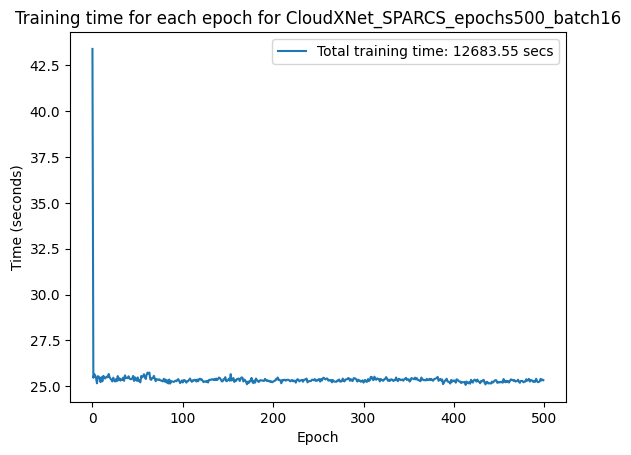

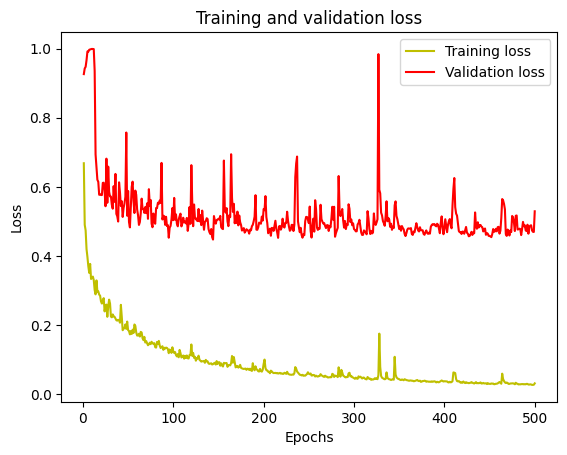

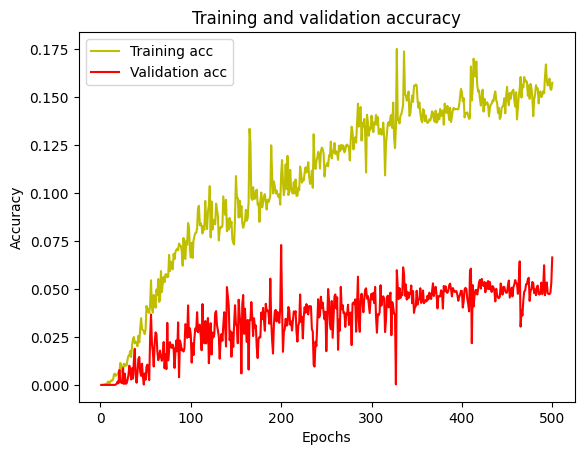

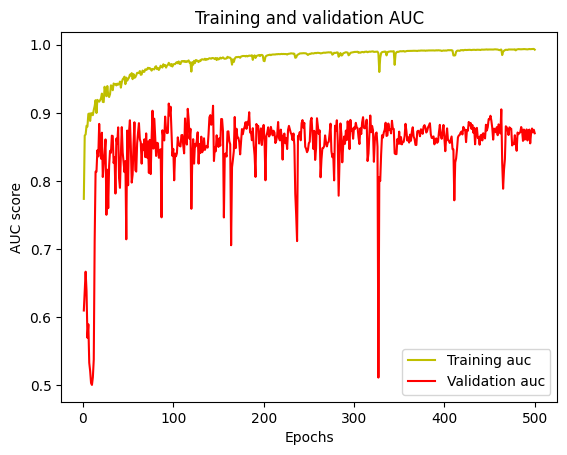

In [31]:
# plt.figure(figsize=(10,6))
plt.plot(time_callback.times, label=f'Total training time: {sum(time_callback.times):.2f} secs')
plt.ylabel('Time (seconds)')
plt.xlabel('Epoch')
plt.title(f'Training time for each epoch for {model_name}')
plt.legend()  # This displays the legend

# Save the figure
plt.savefig(os.path.join(log_dir, 'training_time.png'))

plt.show()

#plot the training and validation metric and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title(f'Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the figure
plt.savefig(os.path.join(log_dir, 'loss.png'))

plt.show()


# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Save the figure
# plt.savefig(os.path.join(log_dir, 'acc.png'))

# plt.show()


acc = history.history['auc']
val_acc = history.history['val_auc']
plt.plot(epochs, acc, 'y', label='Training auc')
plt.plot(epochs, val_acc, 'r', label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC score')
plt.legend()

# Save the figure
plt.savefig(os.path.join(log_dir, 'auc.png'))

plt.show()

In [ ]:
# auc = history.history['iou']
# val_auc = history.history['val_iou']

# plt.plot(epochs, auc, 'y', label='Training IOU')
# plt.plot(epochs, val_auc, 'r', label='Validation IOU')
# plt.title('Training and validation Intersection Over Union')
# plt.xlabel('Epochs')
# plt.ylabel('IOU')
# plt.legend()

# # Save the figure
# plt.savefig(os.path.join(log_dir, 'score.png'))

# plt.show()

## Evaluate

In [33]:
y_test.shape
# np.expand_dims(y_test, -1)
X_test.shape


(256, 256, 256, 3)

In [34]:
# test_image_names = sorted(os.listdir(Path(sparcs_test_dir, "images_p/")))

# # Define number of steps
# steps = math.ceil(len(test_image_names) / batch_size)

# y_pred=model.predict(test, steps=steps) # NOTE: Using the test generator you need to reset it after avery predict
# y_pred_thresholded = y_pred > 0.5

In [35]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

8/8 [==============================] - 1s 113ms/step


In [36]:
# Cast to float types
y_true_f = y_test.astype('float32')
y_pred_f = y_pred_thresholded.astype('float32')

y_true_flatten = y_true_f.reshape(-1)
y_pred_flatten = y_pred_f.reshape(-1)

# Jaccard Score
jaccard = jaccard_score(y_true_flatten, y_pred_flatten)
print("Jaccard Score (IoU): ", jaccard)

Jaccard Score (IoU):  0.6539238330164421


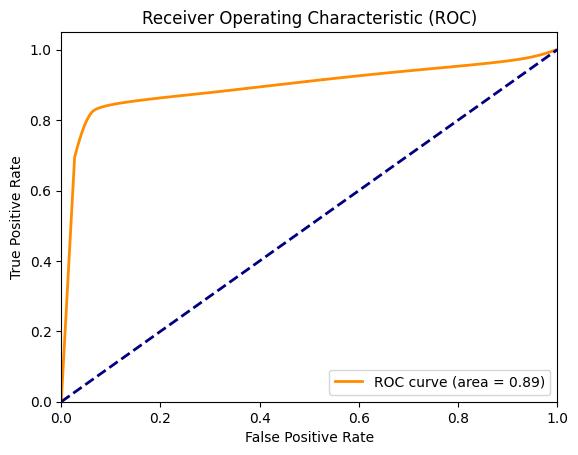

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = y_test.flatten()
y_score = y_pred.flatten()

fpr, tpr, _ = roc_curve(y_true, y_score)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Save the figure
plt.savefig(os.path.join(log_dir, 'roc.png'))

plt.show()


## Save

In [ ]:
model.save(Path(saved_models_path, model_name))

# Save training history
with open(Path(train_hystory_path, f'{model_name}.json'), 'w') as f:
    json.dump(history.history, f)

# model.save('rsnet_adam_100.h5')

## Load full model

In [ ]:
custom_metrics = {'jaccard_coef': jaccard_coef, 'jaccard_coef_thresholded':jaccard_coef_thresholded, 'jaccard_coef_loss':jaccard_coef_loss}

In [ ]:
new_model = tf.keras.models.load_model(Path(saved_models_path, model_name))
# new_model = tf.keras.models.load_model(Path(saved_models_path, model_name), custom_objects=custom_metrics)

# Load training history
with open(Path(train_hystory_path, f'{model_name}.json'), 'r') as f:
    loaded_history = json.load(f)

# Check its architecture
new_model.summary()

In [ ]:
model = new_model
history = loaded_history

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
auc = history['auc']
val_auc = history['val_auc']

plt.plot(epochs, auc, 'y', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Load weights / Resume training

In [19]:
ckpt_path = str(checkpoint_path / "UNet_SPARCS_epochs300_batch16" / "cp-{epoch:04d}.ckpt")
ckpt_dir = os.path.dirname(ckpt_path)

# Upload the last checkpoint
latest = tf.train.latest_checkpoint(ckpt_dir)

# Create a new model instance
model = create_model(model_name='unet')

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, metric = model.evaluate(test, verbose=2)
print(f"Restored model, IOU: {metric}")

2023-07-28 08:44:45.711794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 08:44:46.187560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22309 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
# Upload the last checkpoint
latest = tf.train.latest_checkpoint(ckpt_dir)

# Create a new model instance
model = get_model(model_name='unet')

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, metric = model.evaluate(test, verbose=2)
print(f"Restored model, AUC: {metric}")

## Predict

In [ ]:
def load_sparcs():
    # Create two instances of the test generator
    test_gen_pred = get_SPARCS_generator('test', batch_size=batch_size, only_rgb=train_with_RGB)

    test_image_names = sorted(os.listdir(Path(sparcs_test_dir, "images_p/")))

    # Define number of steps
    steps = math.ceil(len(test_image_names) / batch_size)

    # Predict on the test data
    y_pred_sparcs = model.predict(test_gen_pred, steps=steps)

    # Collect true labels
    y_true_sparcs = get_SPARCS('test', only_rgb=train_with_RGB)[1]

    print(y_true_sparcs.shape, y_pred_sparcs.shape)

    return y_true_sparcs, y_pred_sparcs

In [ ]:
y_true, y_pred = load_sparcs()

In [ ]:
np.unique(y_true), np.unique(y_pred)

In [ ]:
score = iou(y_true, y_pred)
print(score)

In [ ]:
# import cv2
# import numpy as np

# def resize_image(image, new_dim=(1024, 1024)):
#     return cv2.resize(image, new_dim, interpolation = cv2.INTER_NEAREST)

import numpy as np
from skimage.transform import resize

def resize_image(image, new_dim=(1024, 1024, 3)):
    resized_image = resize(image, new_dim, mode='edge', preserve_range=True, anti_aliasing=False, anti_aliasing_sigma=None, order=0)
    return resized_image

In [ ]:
images = resize_image(images, new_dim=((8, 1024, 1024, 3)))
masks = resize_image(masks, new_dim=((8, 1024, 1024, 1)))

images.shape, masks.shape

In [ ]:
X = resize_image(get_SPARCS('test', full_image=True, binary=True)[0], new_dim=((8, 1024, 1024, 4)))

In [ ]:
preds = model.predict(X)
preds = (preds > 0.5).astype(np.uint8)
preds.shape

In [ ]:
fig, ax = plt.subplots(len(images), 3, figsize=(10, 25))

for i, im in enumerate(images):
    # inputs, targets = test_list[idx]
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    ax[i, 1].imshow(masks[i], cmap='gray')
    ax[i, 1].set_title('True mask')
    ax[i, 2].imshow(preds[i], cmap='gray')
    ax[i, 2].set_title('Predicted mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud Detection Results on SPARCS')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Display the figure
plt.show()

In [ ]:
fig, ax = plt.subplots(len(images), 2, figsize=(10, 30))

for i, im in enumerate(images):
    # Remove singleton dimensions from preds[i]
    mask = np.squeeze(preds[i])
    
    # Create an RGB mask where the masked region is light blue
    rgb_mask = np.zeros((*mask.shape, 3))
    rgb_mask[mask == 1] = [0, 0, 1]  # Light blue color for the mask
    
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    
    ax[i, 1].imshow(im)
    ax[i, 1].imshow(rgb_mask, alpha=0.3)  # Adjust alpha for desired transparency
    ax[i, 1].set_title('RGB Image with mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud masking on SPARCS')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the figure
plt.show()

In [ ]:
S2_images, S2_masks = get_S2('test', only_rgb=True)
X = get_S2('test')[0]
y_pred_S2 = model.predict(X)
y_pred_binary_S2 = (y_pred_S2 > 0.1).astype(np.uint8)
y_pred_binary_S2.shape

In [ ]:
np.random.seed(seed_value)
idxs = np.random.randint(len(S2_images), size=10)

fig, ax = plt.subplots(len(idxs), 3, figsize=(10, 20))

for i, idx in enumerate(idxs):
    ax[i, 0].imshow(S2_images[idx])
    ax[i, 0].set_title('RGB Image')
    ax[i, 1].imshow(S2_masks[idx], cmap='gray')
    ax[i, 1].set_title('True mask')
    ax[i, 2].imshow(y_pred_binary_S2[idx], cmap='gray')
    ax[i, 2].set_title('Predicted mask')

# Add a title for the entire plot
plt.suptitle('Cloud Detection Results on Sentinel-2')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Display the figure
plt.show()

In [ ]:
fig, ax = plt.subplots(len(idxs), 2, figsize=(10, 30))

for i, idx in enumerate(idxs):
    # Remove singleton dimensions from preds[i]
    mask = np.squeeze(y_pred_binary_S2[idx])
    
    # Create an RGB mask where the masked region is light blue
    rgb_mask = np.zeros((*mask.shape, 3))
    rgb_mask[mask == 1] = [0, 0, 1]  # Light blue color for the mask
    
    ax[i, 0].imshow(S2_images[idx])
    ax[i, 0].set_title('RGB Image')
    
    ax[i, 1].imshow(S2_images[idx])
    ax[i, 1].imshow(rgb_mask, alpha=0.3)  # Adjust alpha for desired transparency
    ax[i, 1].set_title('RGB Image with mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud masking on Sentinel-2')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the figure
plt.show()

In [ ]:
mask = tiff.imread('../Data/L8_Biome8/test/masks/LC81490122013218LGN00.tif')

In [ ]:
mask.shape

In [ ]:
biome_images, biome_masks = get_biome8('test', only_rgb=True, full_image=True)

In [ ]:
biome_images.shape, biome_masks.shape

In [ ]:
import math

batch_size = 32
total_images = len(os.listdir(biome_test_dir / "images/"))  # assuming your images are in this directory

# Calculate the number of steps
steps = math.ceil(total_images / batch_size)

# Create the generator
biome_generator = get_biome8_generator('test', batch_size=batch_size, full_image=True)

# Use the predict method directly on the generator
biome_preds = model.predict(biome_generator, steps=steps)

# Apply threshold
biome_preds = (biome_preds > 0.7).astype(np.uint8)

print(biome_preds.shape)


In [ ]:
fig, ax = plt.subplots(len(biome_images), 3, figsize=(10, 40))

for i, im in enumerate(biome_images):
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    ax[i, 1].imshow(biome_masks[i], cmap='gray')
    ax[i, 1].set_title('True mask')
    ax[i, 2].imshow(biome_preds[i], cmap='gray')
    ax[i, 2].set_title('Predicted mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud Detection Results on Biome')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Display the figure
plt.show()

In [ ]:
fig, ax = plt.subplots(len(biome_images), 2, figsize=(10, 30))

for i, im in enumerate(biome_images):
    # Remove singleton dimensions from preds[i]
    mask = np.squeeze(biome_preds[i])
    
    # Create an RGB mask where the masked region is light blue
    rgb_mask = np.zeros((*mask.shape, 3))
    rgb_mask[mask == 1] = [0, 0, 1]  # Light blue color for the mask
    
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    
    ax[i, 1].imshow(im)
    ax[i, 1].imshow(rgb_mask, alpha=0.3)  # Adjust alpha for desired transparency
    ax[i, 1].set_title('RGB Image with mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud masking on Biome')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the figure
plt.show()